In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.stats import t
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('/Users/zhangnele/Downloads/Projects/Quantium/QVI_data.csv')

In [3]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period. 

#### Calculate these measures over time for each store

In [4]:
# Add a new month ID column in the data with the format yyyymm
df.DATE = pd.to_datetime(df.DATE)

In [5]:
df['year_month'] = df['DATE'].dt.strftime('%Y%m')

#### Next, we define the measure calculations to use during the analysis.

In [6]:
# For each store and month calculate total sales, number of customers,
# transactions per customer, chips per customer and the average price per unit.
df_store = pd.pivot_table(df, values = 'TOT_SALES', index = ['STORE_NBR', 'year_month'], aggfunc = 'sum')

In [7]:
df_store.head()

TOT_SALES
STORE_NBR year_month           
1         201807          206.9
          201808          176.1
          201809          278.8
          201810          188.1
          201811          192.6

In [8]:
df_store['number_customer'] = df.groupby(['STORE_NBR', 'year_month']).LYLTY_CARD_NBR.nunique()

In [9]:
df_store['trans_per_customer'] = df.groupby(['STORE_NBR', 'year_month']).TXN_ID.nunique() / df.groupby(['STORE_NBR', 'year_month']).LYLTY_CARD_NBR.nunique()

In [10]:
df_store['chips_per_customer'] = df.groupby(['STORE_NBR', 'year_month']).PROD_QTY.sum()/df.groupby(['STORE_NBR', 'year_month']).LYLTY_CARD_NBR.nunique()

In [11]:
df_store['avg_price'] = df.groupby(['STORE_NBR', 'year_month']).TOT_SALES.sum()/df.groupby(['STORE_NBR', 'year_month']).PROD_QTY.sum()

#### Filter to the pre-trial period and stores with full observation periods

In [12]:
a = pd.pivot_table(df, values = 'TXN_ID', index = 'STORE_NBR', columns = 'year_month', aggfunc = 'count')
a.head()

year_month,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0


In [13]:
a.isnull().sum()

year_month
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

In [14]:
null_stores = a[a.isnull().any(axis = 1)].index.tolist()
null_stores

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [15]:
df_store.reset_index(inplace = True)

In [16]:
# stores without null values
df_store = df_store[~df_store.STORE_NBR.isin(null_stores)]

In [17]:
# filter the stores info before 201902
df_store_past = df_store[df_store.year_month < '201902']

In [18]:
len(df_store_past)

1820

In [19]:
df_store_past.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [20]:
# Create a function which calculates the correlation between trial store and other stores based on a single metric
def calculateCorrelation(inputTable, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation': []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)}, ignore_index = True)
    return output

In [21]:
def calculateMagnitudeDistance(inputTable, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude' : []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output = output.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d}, ignore_index = True)
    return output

### Select control store for trial store 77

In [22]:
#Now let's use the functions to find the control stores! We'll select control stores
#based on how similar monthly total sales in dollar amounts and monthly number of
#customers are to the trial stores. So we will need to use our functions to get four
#scores, two for each of total sales and total customers.
corr_sales = calculateCorrelation(df_store_past, 'TOT_SALES', 77)
corr_customer = calculateCorrelation(df_store_past, 'number_customer', 77)

In [23]:
magnitude_sales = calculateMagnitudeDistance(df_store_past, 'TOT_SALES', 77)
magnitude_customer = calculateMagnitudeDistance(df_store_past, 'number_customer', 77)

In [24]:
score_sales = pd.concat([corr_sales, magnitude_sales['Magnitude']], axis= 1)

In [25]:
score_sales.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.075218,0.408163
1,77.0,2.0,-0.263079,0.590119
2,77.0,3.0,0.806644,0.522914
3,77.0,4.0,-0.263300,0.644934
4,77.0,5.0,-0.110652,0.516320


In [26]:
score_customer = pd.concat([corr_customer, magnitude_customer['Magnitude']], axis= 1)

In [27]:
score_customer.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.322168,0.663866
1,77.0,2.0,-0.572051,0.471429
2,77.0,3.0,0.834207,0.489796
3,77.0,4.0,-0.295639,0.498258
4,77.0,5.0,0.370659,0.512605


In [28]:
weight = 0.5
score_sales['total_Sscore'] = score_sales['Correlation']*weight + score_sales['Magnitude']*(1-weight)
score_customer['total_Cscore'] = score_customer['Correlation']*weight + score_customer['Magnitude']*(1-weight)

In [29]:
score_sales.set_index(['Store1', 'Store2'], inplace = True)

In [30]:
score_customer.set_index(['Store1', 'Store2'], inplace = True)

In [31]:
score_customer.head()

Correlation  Magnitude  total_Cscore
Store1 Store2                                      
77.0   1.0        0.322168   0.663866      0.493017
       2.0       -0.572051   0.471429     -0.050311
       3.0        0.834207   0.489796      0.662002
       4.0       -0.295639   0.498258      0.101310
       5.0        0.370659   0.512605      0.441632

In [32]:
score_control = pd.concat([score_sales['total_Sscore'], score_customer['total_Cscore']], axis=1)

In [33]:
score_control.head()

total_Sscore  total_Cscore
Store1 Store2                            
77.0   1.0         0.241691      0.493017
       2.0         0.163520     -0.050311
       3.0         0.664779      0.662002
       4.0         0.190817      0.101310
       5.0         0.202834      0.441632

In [34]:
score_control['final_score'] = (score_control['total_Sscore']+score_control['total_Cscore'])/2

In [35]:
score_control.head()

total_Sscore  total_Cscore  final_score
Store1 Store2                                         
77.0   1.0         0.241691      0.493017     0.367354
       2.0         0.163520     -0.050311     0.056604
       3.0         0.664779      0.662002     0.663390
       4.0         0.190817      0.101310     0.146064
       5.0         0.202834      0.441632     0.322233

In [36]:
score_control.sort_values(by='final_score', ascending = False).head()
# Store 233 is most similiar to store 77 

total_Sscore  total_Cscore  final_score
Store1 Store2                                         
77.0   233.0       0.697290      0.816607     0.756949
       71.0        0.789497      0.663123     0.726310
       84.0        0.656972      0.715000     0.685986
       119.0       0.636046      0.729729     0.682887
       115.0       0.708347      0.645155     0.676751

In [37]:
control_store = 233
trial_store = 77
past_sales = df_store_past
past_sales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [38]:
store_type = []
for i in past_sales['STORE_NBR']:
    if i == trial_store:
        store_type.append('trial_store')
    elif i == control_store:
        store_type.append('control_store')
    else:
        store_type.append('other_type')
past_sales['store_type'] = store_type

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
past_sales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,store_type
0,1,201807,206.9,49,1.061224,1.265306,3.337097,other_type
1,1,201808,176.1,42,1.023810,1.285714,3.261111,other_type
2,1,201809,278.8,59,1.050847,1.271186,3.717333,other_type
3,1,201810,188.1,44,1.022727,1.318182,3.243103,other_type
4,1,201811,192.6,46,1.021739,1.239130,3.378947,other_type


In [40]:
trial_sales = past_sales.loc[past_sales['store_type']=='trial_store', ['year_month', 'TOT_SALES']]
trial_sales.set_index('year_month', inplace = True)
trial_sales.rename(columns = {'TOT_SALES': 'Trial Store'}, inplace = True)

In [41]:
trial_sales.head()

,Trial Store
year_month,
201807,296.8
201808,255.5
201809,225.2
201810,204.5
201811,245.3


In [42]:
control_sales = past_sales.loc[past_sales['store_type']=='control_store', ['year_month', 'TOT_SALES']]
control_sales.set_index('year_month', inplace = True)
control_sales.rename(columns = {'TOT_SALES':'Control Store'}, inplace = True)

In [43]:
other_sales = past_sales.loc[past_sales['store_type']=='other_type', ['year_month', 'TOT_SALES']]

other_sales = pd.DataFrame(other_sales.groupby('year_month').TOT_SALES.mean())
other_sales.rename(columns = {'TOT_SALES':'Other Store'}, inplace = True)

In [44]:
other_sales.head()

,Other Store
year_month,
201807,638.004651
201808,610.223450
201809,620.198450
201810,635.314729
201811,618.864341


In [45]:
combine_sales = pd.concat([trial_sales, control_sales, other_sales], axis = 1)
combine_sales

,Trial Store,Control Store,Other Store
year_month,,,
201807,296.8,290.7,638.004651
201808,255.5,285.9,610.223450
201809,225.2,228.6,620.198450
201810,204.5,185.7,635.314729
201811,245.3,211.6,618.864341
201812,267.3,279.8,648.453876
201901,204.4,177.5,628.684496


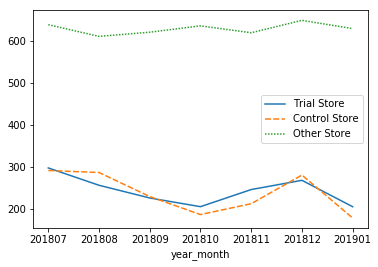

In [46]:
sns.lineplot(data = combine_sales);

In [47]:
past_sales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,store_type
0,1,201807,206.9,49,1.061224,1.265306,3.337097,other_type
1,1,201808,176.1,42,1.023810,1.285714,3.261111,other_type
2,1,201809,278.8,59,1.050847,1.271186,3.717333,other_type
3,1,201810,188.1,44,1.022727,1.318182,3.243103,other_type
4,1,201811,192.6,46,1.021739,1.239130,3.378947,other_type


In [48]:
trial_customer = past_sales.loc[past_sales['store_type'] == 'trial_store', ['year_month', 'number_customer']]
trial_customer.set_index('year_month', inplace = True)
trial_customer.rename(columns = {'number_customer': 'Trial Store'}, inplace = True)

In [49]:
control_customer = past_sales.loc[past_sales['store_type'] == 'control_store', ['year_month', 'number_customer']]
control_customer.set_index('year_month', inplace = True)
control_customer.rename(columns = {'number_customer': 'Control Store'}, inplace = True)

In [50]:
other_customer = past_sales.loc[past_sales['store_type'] == 'other_type', ['year_month', 'number_customer']]
other_customer = pd.DataFrame(other_customer.groupby('year_month').number_customer.mean())
other_customer.rename(columns = {'number_customer': 'Other Store'}, inplace = True)

In [51]:
combine_customer = pd.concat([trial_customer, control_customer, other_customer], axis = 1)

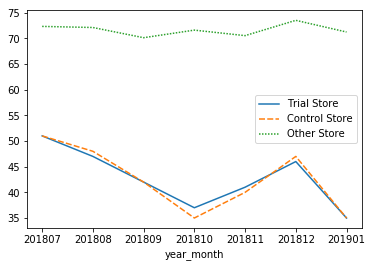

In [52]:
sns.lineplot(data = combine_customer);

## Assessment of trial of trial store 77
The trial period goes from the start of February 2019 to April 2019. 
We now want to see if there has been an uplift in overall chip sales.

We'll start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period. 

In [53]:
past_sales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,store_type
0,1,201807,206.9,49,1.061224,1.265306,3.337097,other_type
1,1,201808,176.1,42,1.023810,1.285714,3.261111,other_type
2,1,201809,278.8,59,1.050847,1.271186,3.717333,other_type
3,1,201810,188.1,44,1.022727,1.318182,3.243103,other_type
4,1,201811,192.6,46,1.021739,1.239130,3.378947,other_type


In [54]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'TOT_SALES' for trial store by sum of 'TOT_SALES' for control store
# Let's call this variable 'scalingFactorSales'
scalingFactorSales = past_sales.loc[past_sales['store_type'] == 'trial_store'].TOT_SALES.sum()/past_sales.loc[past_sales['store_type'] == 'control_store'].TOT_SALES.sum()

In [55]:
scalingFactorSales

1.023617303289553

In [57]:
scaledControlSales = df_store

In [58]:
scaledControlSales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [59]:
scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
2699,233,201807,290.7,51,1.058824,1.725490,3.303409
2700,233,201808,285.9,48,1.041667,1.666667,3.573750
2701,233,201809,228.6,42,1.071429,1.666667,3.265714
2702,233,201810,185.7,35,1.028571,1.600000,3.316071
2703,233,201811,211.6,40,1.025000,1.550000,3.412903
2704,233,201812,279.8,47,1.063830,1.595745,3.730667
2705,233,201901,177.5,35,1.000000,1.342857,3.776596
2706,233,201902,244.0,45,1.044444,1.555556,3.485714
2707,233,201903,199.1,40,1.025000,1.475000,3.374576
2708,233,201904,158.6,30,1.066667,1.533333,3.447826


In [60]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column
scaledControlSales['controlSales'] = scaledControlSales['TOT_SALES'] * scalingFactorSales
scaledControlSales.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,controlSales
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,216.597421


In [61]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['year_month', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = df_store.loc[df_store['STORE_NBR'] == trial_store, 'TOT_SALES']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'TOT_SALES': 'trialSales'}, inplace = True)

In [62]:
percentageDiff.head()

,year_month,controlSales,trialSales
0,201807,297.565550,296.8
1,201808,292.652187,255.5
2,201809,233.998916,225.2
3,201810,190.085733,204.5
4,201811,216.597421,245.3


In [63]:
# Calculate percentage difference and put it in a new column
percentageDiff['percentageDiff']=abs(percentageDiff.controlSales-percentageDiff.trialSales)/percentageDiff.controlSales

In [64]:
percentageDiff.head()

,year_month,controlSales,trialSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516


In [65]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = np.std(percentageDiff.loc[percentageDiff['year_month'] < '201902', 'percentageDiff'])
stdDev

0.046236161851401905

In [66]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7
dof = 7

In [67]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['year_month'] > '201901') & (percentageDiff['year_month'] < '201905'), ['year_month','tValue']]

,year_month,tValue
7,201902,1.278363
8,201903,7.927151
9,201904,13.476023


In [76]:
# Find the 95th percentile of the t distribution with dof = 7
t.isf(0.05, dof)
# Comment: We can see that the t-value is much larger than the 95th percentile value of the t-distribution 
# for March and April, so difference of sales between control and trial store is significant.

1.8945786050613054

In [77]:
scaledControlSales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,controlSales
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,216.597421


In [78]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 
controlSales = pd.pivot_table(scaledControlSales, index = 'year_month', values = 'controlSales')
controlSales.head()

,controlSales
year_month,
201807,297.565550
201808,292.652187
201809,233.998916
201810,190.085733
201811,216.597421


In [79]:
trialSales = df_store.loc[df_store['STORE_NBR'] == trial_store]
trialSales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
880,77,201807,296.8,51,1.078431,1.647059,3.533333
881,77,201808,255.5,47,1.021277,1.574468,3.452703
882,77,201809,225.2,42,1.047619,1.666667,3.217143
883,77,201810,204.5,37,1.027027,1.405405,3.932692
884,77,201811,245.3,41,1.073171,1.634146,3.661194


In [80]:
trialSales = pd.pivot_table(trialSales, index='year_month', values='TOT_SALES')
trialSales.rename(columns={'TOT_SALES':'trialSales'}, inplace=True)

In [81]:
trialSales.head()

,trialSales
year_month,
201807,296.8
201808,255.5
201809,225.2
201810,204.5
201811,245.3


In [82]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['controlSales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['controlSales'] * (1 + stdDev*2)
controlSales

,controlSales,Control 5% Confidence Interval,Control 95% Confidence Interval
year_month,,,
201807,297.565550,270.048972,325.082128
201808,292.652187,265.589959,319.714415
201809,233.998916,212.360492,255.637339
201810,190.085733,172.508064,207.663403
201811,216.597421,196.568155,236.626688
201812,286.408121,259.923297,312.892946
201901,181.692071,164.890583,198.493559
201902,249.762622,226.666492,272.858752
201903,203.802205,184.956142,222.648269


In [83]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,controlSales,Control 5% Confidence Interval,Control 95% Confidence Interval,trialSales
year_month,,,,
201807,297.565550,270.048972,325.082128,296.8
201808,292.652187,265.589959,319.714415,255.5
201809,233.998916,212.360492,255.637339,225.2
201810,190.085733,172.508064,207.663403,204.5
201811,216.597421,196.568155,236.626688,245.3
201812,286.408121,259.923297,312.892946,267.3
201901,181.692071,164.890583,198.493559,204.4
201902,249.762622,226.666492,272.858752,235.0
201903,203.802205,184.956142,222.648269,278.5


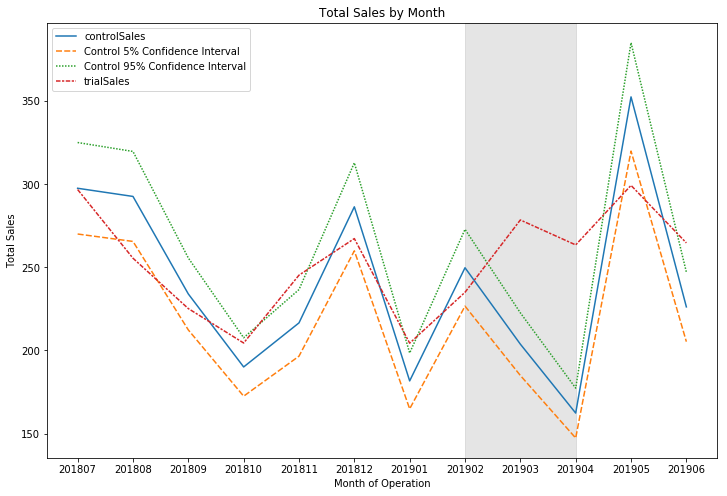

In [84]:
plt.figure(figsize = (12, 8))
sns.lineplot(data=combineSales)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.axvspan('201902','201904', color = 'grey', alpha = 0.2);

In [118]:
#Comment: The results show that the trial in store 77 is significantly different to its
#control store in the trial period as the trial store performance lies outside the
#5% to 95% confidence interval of the control store in two of the three trial
#months.

In [85]:
# Let's have a look at assessing this for number of customers as well.
df_store.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [90]:
factorCusts = df_store[(df_store['year_month']<'201902')&(df_store['STORE_NBR']==trial_store)].number_customer.sum()/df_store[(df_store['year_month']<'201902')&(df_store['STORE_NBR']==control_store)].number_customer.sum()
factorCusts

1.0033557046979866

In [91]:
scaledControlCusts = df_store

In [93]:
scaledControlCusts = scaledControlCusts.loc[scaledControlCusts['STORE_NBR'] == control_store]

In [94]:
scaledControlCusts.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
2699,233,201807,290.7,51,1.058824,1.725490,3.303409
2700,233,201808,285.9,48,1.041667,1.666667,3.573750
2701,233,201809,228.6,42,1.071429,1.666667,3.265714
2702,233,201810,185.7,35,1.028571,1.600000,3.316071
2703,233,201811,211.6,40,1.025000,1.550000,3.412903


In [95]:
scaledControlCusts['controlCusts'] = scaledControlCusts['number_customer']*factorCusts

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
scaledControlCusts.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,controlCusts
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,51.171141
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,48.161074
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,42.140940
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,35.117450
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,40.134228


In [99]:
# Create 'percentageDiff' dataframe
percentageDiffCusts = scaledControlCusts[['year_month', 'controlCusts']]
percentageDiffCusts.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'number_customer'
trialCusts = df_store.loc[df_store['STORE_NBR'] == trial_store, 'number_customer']
trialCusts.reset_index(drop = True, inplace = True)
percentageDiffCusts = pd.concat([percentageDiffCusts, trialCusts], axis = 1)
percentageDiffCusts.rename(columns = {'number_customer': 'trialCusts'}, inplace = True)

In [101]:
percentageDiffCusts.head()

,year_month,controlCusts,trialCusts
0,201807,51.171141,51
1,201808,48.161074,47
2,201809,42.140940,42
3,201810,35.117450,37
4,201811,40.134228,41


In [102]:
# Calculate percentage difference and put it in a new column
percentageDiffCusts['percentageDiff']=abs(percentageDiffCusts.controlCusts-percentageDiffCusts.trialCusts)/percentageDiffCusts.controlCusts



In [103]:
percentageDiffCusts.head()

,year_month,controlCusts,trialCusts,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572


In [104]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = np.std(percentageDiffCusts.loc[percentageDiffCusts['year_month'] < '201902', 'percentageDiff'])
stdDev

0.016887651650119434

In [105]:
# Define the degrees of freedom
# Since we have 8 pre-trial months, dof = 8 - 1 = 7
dof = 7

In [106]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'
percentageDiffCusts['tValue'] = (percentageDiffCusts['percentageDiff'] - 0) / stdDev
percentageDiffCusts.loc[(percentageDiffCusts['year_month'] > '201901') & (percentageDiffCusts['year_month'] < '201905'), ['year_month','tValue']]

,year_month,tValue
7,201902,0.198043
8,201903,14.556162
9,201904,33.244822


In [108]:
# Find the 95th percentile of the t distribution with dof = 7
t.isf(0.05, dof)
# Comment: We can see that the t-value is much larger than the 95th percentile value of the t-distribution 
# for March and April, so difference of customer numbers between control and trial store is significant.

1.8945786050613054

In [109]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlCusts' from 'scaledControlCusts' dataframe for control store 
controlCusts = pd.pivot_table(scaledControlCusts, index = 'year_month', values = 'controlCusts')
controlCusts.head()

,controlCusts
year_month,
201807,51.171141
201808,48.161074
201809,42.140940
201810,35.117450
201811,40.134228


In [110]:
trialCusts = df_store.loc[df_store['STORE_NBR'] == trial_store]
trialCusts.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price
880,77,201807,296.8,51,1.078431,1.647059,3.533333
881,77,201808,255.5,47,1.021277,1.574468,3.452703
882,77,201809,225.2,42,1.047619,1.666667,3.217143
883,77,201810,204.5,37,1.027027,1.405405,3.932692
884,77,201811,245.3,41,1.073171,1.634146,3.661194


In [111]:
trialCusts = pd.pivot_table(trialCusts, index='year_month', values='number_customer')
trialCusts.rename(columns={'number_customer':'trialCusts'}, inplace=True)

In [114]:
trialCusts.head()

,trialCusts
year_month,
201807,51
201808,47
201809,42
201810,37
201811,41


In [116]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlCusts['Control 5% Confidence Interval'] = controlCusts['controlCusts'] * (1 - stdDev*2)
controlCusts['Control 95% Confidence Interval'] = controlCusts['controlCusts'] * (1 + stdDev*2)
controlCusts

,controlCusts,Control 5% Confidence Interval,Control 95% Confidence Interval
year_month,,,
201807,51.171141,49.442820,52.899462
201808,48.161074,46.534419,49.787729
201809,42.140940,40.717617,43.564263
201810,35.117450,33.931347,36.303552
201811,40.134228,38.778682,41.489774
201812,47.157718,45.564952,48.750484
201901,35.117450,33.931347,36.303552
201902,45.151007,43.626018,46.675996
201903,40.134228,38.778682,41.489774


In [117]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCusts = pd.merge(controlCusts, trialCusts, left_index = True, right_index = True)
combineCusts

,controlCusts,Control 5% Confidence Interval,Control 95% Confidence Interval,trialCusts
year_month,,,,
201807,51.171141,49.442820,52.899462,51
201808,48.161074,46.534419,49.787729,47
201809,42.140940,40.717617,43.564263,42
201810,35.117450,33.931347,36.303552,37
201811,40.134228,38.778682,41.489774,41
201812,47.157718,45.564952,48.750484,46
201901,35.117450,33.931347,36.303552,35
201902,45.151007,43.626018,46.675996,45
201903,40.134228,38.778682,41.489774,50


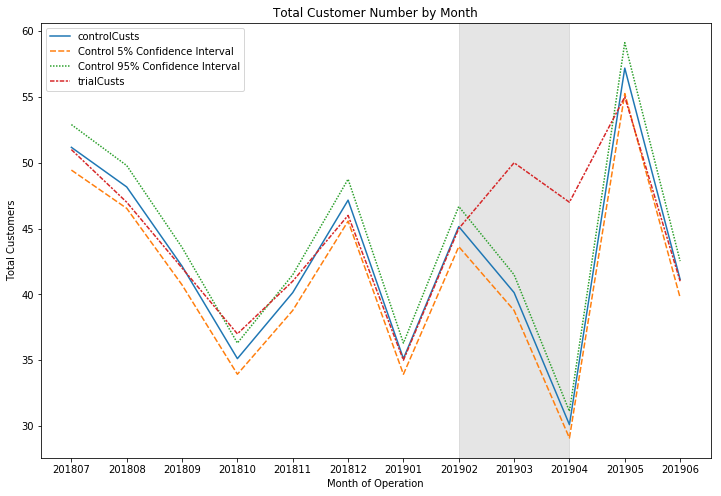

In [120]:
plt.figure(figsize = (12, 8))
sns.lineplot(data=combineCusts)
plt.title('Total Customer Number by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.axvspan('201902','201904', color = 'grey', alpha = 0.2);

In [121]:
#Comment: The results show that the trial in store 77 is significantly different to its
#control store in the trial period as the trial store performance lies outside the
#5% to 95% confidence interval of the control store in two of the three trial
#months.The number of customers was increased, so the sales increases in trial period.

Select control store for trial store 86

In [189]:
def lookforControl(trial_store):
    corr_sales = calculateCorrelation(df_store_past, 'TOT_SALES', trial_store)
    corr_customer = calculateCorrelation(df_store_past, 'number_customer', trial_store)
    magnitude_sales = calculateMagnitudeDistance(df_store_past, 'TOT_SALES', trial_store)
    magnitude_customer = calculateMagnitudeDistance(df_store_past, 'number_customer', trial_store)
    score_sales = pd.concat([corr_sales, magnitude_sales['Magnitude']], axis= 1)
    score_customer = pd.concat([corr_customer, magnitude_customer['Magnitude']], axis= 1)
    weight = 0.5
    score_sales['total_Sscore'] = score_sales['Correlation']*weight + score_sales['Magnitude']*(1-weight)
    score_customer['total_Cscore'] = score_customer['Correlation']*weight + score_customer['Magnitude']*(1-weight)
    score_sales.set_index(['Store1', 'Store2'], inplace = True)
    score_customer.set_index(['Store1', 'Store2'], inplace = True)
    score_control = pd.concat([score_sales['total_Sscore'], score_customer['total_Cscore']], axis=1)
    score_control['final_score'] = (score_control['total_Sscore']+score_control['total_Cscore'])/2
    score_control.sort_values(by='final_score', ascending = False, inplace=True)
    return score_control.index[0][1]

In [190]:
lookforControl(86)

155.0

In [161]:
# Store 155 is most similiar to store 86 

In [162]:
control_store = 155
trial_store = 86
past_sales = df_store_past
past_sales.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,store_type
0,1,201807,206.9,49,1.061224,1.265306,3.337097,other_type
1,1,201808,176.1,42,1.023810,1.285714,3.261111,other_type
2,1,201809,278.8,59,1.050847,1.271186,3.717333,other_type
3,1,201810,188.1,44,1.022727,1.318182,3.243103,other_type
4,1,201811,192.6,46,1.021739,1.239130,3.378947,other_type


In [163]:
store_type = []
for i in past_sales['STORE_NBR']:
    if i == trial_store:
        store_type.append('trial_store')
    elif i == control_store:
        store_type.append('control_store')
    else:
        store_type.append('other_type')
past_sales['store_type'] = store_type

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [164]:
trial_sales = past_sales.loc[past_sales['store_type']=='trial_store', ['year_month', 'TOT_SALES']]
trial_sales.set_index('year_month', inplace = True)
trial_sales.rename(columns = {'TOT_SALES': 'Trial Store'}, inplace = True)

In [165]:
trial_sales.head()

,Trial Store
year_month,
201807,892.20
201808,764.05
201809,914.60
201810,948.40
201811,918.00


In [191]:
control_sales = past_sales.loc[past_sales['store_type']=='control_store', ['year_month', 'TOT_SALES']]
control_sales.set_index('year_month', inplace = True)
control_sales.rename(columns = {'TOT_SALES':'Control Store'}, inplace = True)

In [192]:
other_sales = past_sales.loc[past_sales['store_type']=='other_type', ['year_month', 'TOT_SALES']]

other_sales = pd.DataFrame(other_sales.groupby('year_month').TOT_SALES.mean())
other_sales.rename(columns = {'TOT_SALES':'Other Store'}, inplace = True)

In [193]:
combine_sales = pd.concat([trial_sales, control_sales, other_sales], axis = 1)

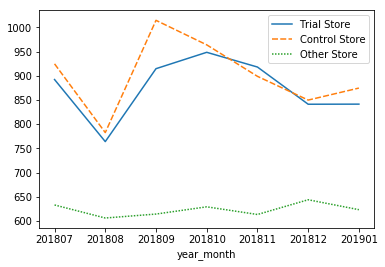

In [194]:
sns.lineplot(data = combine_sales);

In [195]:
trial_customer = past_sales.loc[past_sales['store_type'] == 'trial_store', ['year_month', 'number_customer']]
trial_customer.set_index('year_month', inplace = True)
trial_customer.rename(columns = {'number_customer': 'Trial Store'}, inplace = True)

In [196]:
control_customer = past_sales.loc[past_sales['store_type'] == 'control_store', ['year_month', 'number_customer']]
control_customer.set_index('year_month', inplace = True)
control_customer.rename(columns = {'number_customer': 'Control Store'}, inplace = True)

In [197]:
other_customer = past_sales.loc[past_sales['store_type'] == 'other_type', ['year_month', 'number_customer']]
other_customer = pd.DataFrame(other_customer.groupby('year_month').number_customer.mean())
other_customer.rename(columns = {'number_customer': 'Other Store'}, inplace = True)

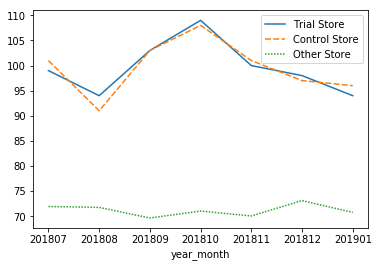

In [198]:
combine_customer = pd.concat([trial_customer, control_customer, other_customer], axis = 1)
sns.lineplot(data = combine_customer);

# Assessment of trial of trial store 86
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

In [211]:
def combineSales(trial_store, control_store):
    scalingFactorSales = past_sales.loc[past_sales['store_type'] == 'trial_store'].TOT_SALES.sum()/past_sales.loc[past_sales['store_type'] == 'control_store'].TOT_SALES.sum()
    scaledControlSales = df_store
    scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
    scaledControlSales['controlSales'] = scaledControlSales['TOT_SALES'] * scalingFactorSales
    percentageDiff = scaledControlSales[['year_month', 'controlSales']]
    percentageDiff.reset_index(drop = True, inplace = True)
    trialSales = df_store.loc[df_store['STORE_NBR'] == trial_store, 'TOT_SALES']
    trialSales.reset_index(drop = True, inplace = True)
    percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
    percentageDiff.rename(columns = {'TOT_SALES': 'trialSales'}, inplace = True)
    percentageDiff['percentageDiff']=abs(percentageDiff.controlSales-percentageDiff.trialSales)/percentageDiff.controlSales
    stdDev = np.std(percentageDiff.loc[percentageDiff['year_month'] < '201902', 'percentageDiff'])
    dof = 7
    percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
    percentageDiff.loc[(percentageDiff['year_month'] > '201901') & (percentageDiff['year_month'] < '201905'), ['year_month','tValue']]
    controlSales = pd.pivot_table(scaledControlSales, index = 'year_month', values = 'controlSales')
    trialSales = df_store.loc[df_store['STORE_NBR'] == trial_store]
    trialSales = pd.pivot_table(trialSales, index='year_month', values='TOT_SALES')
    trialSales.rename(columns={'TOT_SALES':'trialSales'}, inplace=True)
    controlSales['Control 5% Confidence Interval'] = controlSales['controlSales'] * (1 - stdDev*2)
    controlSales['Control 95% Confidence Interval'] = controlSales['controlSales'] * (1 + stdDev*2)
    combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
    plt.figure(figsize = (12, 8))
    sns.lineplot(data=combineSales)
    plt.title('Total Sales by Month')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Sales')
    plt.axvspan('201902','201904', color = 'grey', alpha = 0.2);

    
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


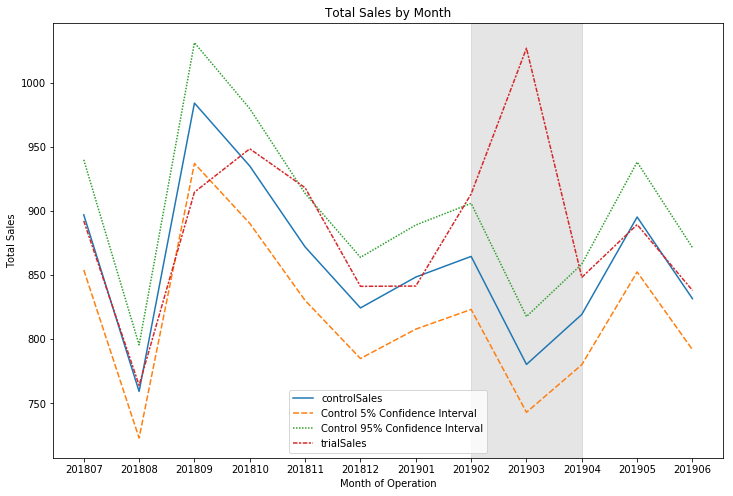

In [212]:
combineSales(trial_store, control_store)

In [213]:
def combineCusts(trial_store, control_store):
    scalingFactorCusts = past_sales.loc[past_sales['store_type'] == 'trial_store'].number_customer.sum()/past_sales.loc[past_sales['store_type'] == 'control_store'].number_customer.sum()
    scaledControlCusts = df_store
    scaledControlCusts = scaledControlCusts.loc[scaledControlCusts['STORE_NBR'] == control_store]
    scaledControlCusts['controlCusts'] = scaledControlCusts['number_customer'] * scalingFactorCusts
    percentageDiffCusts = scaledControlCusts[['year_month', 'controlCusts']]
    percentageDiffCusts.reset_index(drop = True, inplace = True)
    trialCusts = df_store.loc[df_store['STORE_NBR'] == trial_store, 'number_customer']
    trialCusts.reset_index(drop = True, inplace = True)
    percentageDiffCusts = pd.concat([percentageDiffCusts, trialCusts], axis = 1)
    percentageDiffCusts.rename(columns = {'number_customer': 'trialCusts'}, inplace = True)
    percentageDiffCusts['percentageDiff']=abs(percentageDiffCusts.controlCusts-percentageDiffCusts.trialCusts)/percentageDiffCusts.controlCusts
    stdDev = np.std(percentageDiffCusts.loc[percentageDiffCusts['year_month'] < '201902', 'percentageDiff'])
    dof = 7
    percentageDiffCusts['tValue'] = (percentageDiffCusts['percentageDiff'] - 0) / stdDev
    percentageDiffCusts.loc[(percentageDiffCusts['year_month'] > '201901') & (percentageDiffCusts['year_month'] < '201905'), ['year_month','tValue']]
    controlCusts = pd.pivot_table(scaledControlCusts, index = 'year_month', values = 'controlCusts')
    trialCusts = df_store.loc[df_store['STORE_NBR'] == trial_store]
    trialCusts = pd.pivot_table(trialCusts, index='year_month', values='number_customer')
    trialCusts.rename(columns={'number_customer':'trialCusts'}, inplace=True)
    controlCusts['Control 5% Confidence Interval'] = controlCusts['controlCusts'] * (1 - stdDev*2)
    controlCusts['Control 95% Confidence Interval'] = controlCusts['controlCusts'] * (1 + stdDev*2)
    combineCusts = pd.merge(controlCusts, trialCusts, left_index = True, right_index = True)
    plt.figure(figsize = (12, 8))
    sns.lineplot(data=combineCusts)
    plt.title('Total Customer Number by Month')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Customer')
    plt.axvspan('201902','201904', color = 'grey', alpha = 0.2);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


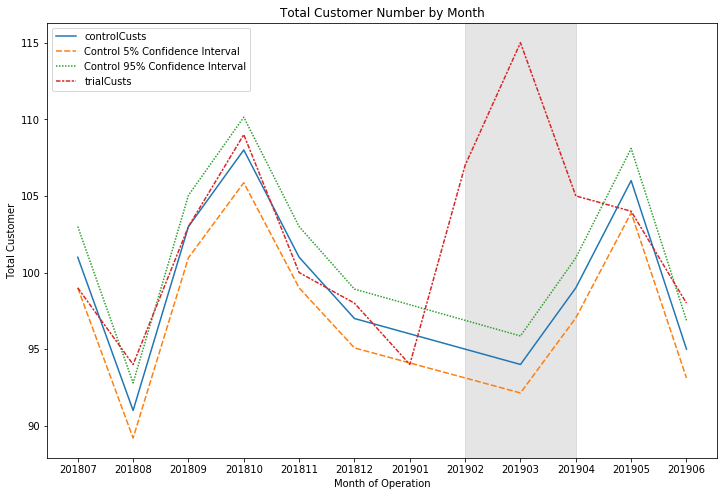

In [215]:
combineCusts(trial_store, control_store)

# Look for control store of trial store 88

In [220]:
trial_store = 88

In [222]:
df_store_past.head()

,STORE_NBR,year_month,TOT_SALES,number_customer,trans_per_customer,chips_per_customer,avg_price,store_type
0,1,201807,206.9,49,1.061224,1.265306,3.337097,other_type
1,1,201808,176.1,42,1.023810,1.285714,3.261111,other_type
2,1,201809,278.8,59,1.050847,1.271186,3.717333,other_type
3,1,201810,188.1,44,1.022727,1.318182,3.243103,other_type
4,1,201811,192.6,46,1.021739,1.239130,3.378947,other_type


In [221]:
corr_sales = calculateCorrelation(df_store_past, 'TOT_SALES', trial_store)
corr_customer = calculateCorrelation(df_store_past, 'number_customer', trial_store)
magnitude_sales = calculateMagnitudeDistance(df_store_past, 'TOT_SALES', trial_store)
magnitude_customer = calculateMagnitudeDistance(df_store_past, 'number_customer', trial_store)
score_sales = pd.concat([corr_sales, magnitude_sales['Magnitude']], axis= 1)
score_customer = pd.concat([corr_customer, magnitude_customer['Magnitude']], axis= 1)
weight = 0.5
score_sales['total_Sscore'] = score_sales['Correlation']*weight + score_sales['Magnitude']*(1-weight)
score_customer['total_Cscore'] = score_customer['Correlation']*weight + score_customer['Magnitude']*(1-weight)
score_sales.set_index(['Store1', 'Store2'], inplace = True)
score_customer.set_index(['Store1', 'Store2'], inplace = True)
score_control = pd.concat([score_sales['total_Sscore'], score_customer['total_Cscore']], axis=1)
score_control['final_score'] = (score_control['total_Sscore']+score_control['total_Cscore'])/2
score_control.sort_values(by='final_score', ascending = False, inplace=True)
score_control.head()

total_Sscore  total_Cscore  final_score
Store1 Store2                                         
88.0   178.0       0.650803      0.707828     0.679316
       14.0        0.646064      0.685774     0.665919
       134.0       0.775084      0.540154     0.657619
       237.0       0.451974      0.777235     0.614604
       187.0       0.616752      0.594560     0.605656

In [232]:
control_store = 237
trial_store = 88
past_sales = df_store_past
store_type = []
for i in past_sales['STORE_NBR']:
    if i == trial_store:
        store_type.append('trial_store')
    elif i == control_store:
        store_type.append('control_store')
    else:
        store_type.append('other_type')
past_sales['store_type'] = store_type

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


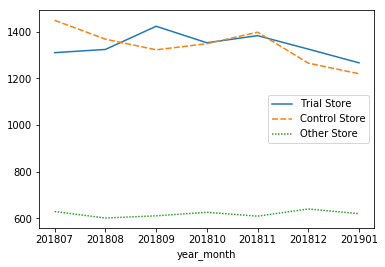

In [233]:
trial_sales = past_sales.loc[past_sales['store_type']=='trial_store', ['year_month', 'TOT_SALES']]
trial_sales.set_index('year_month', inplace = True)
trial_sales.rename(columns = {'TOT_SALES': 'Trial Store'}, inplace = True)
control_sales = past_sales.loc[past_sales['store_type']=='control_store', ['year_month', 'TOT_SALES']]
control_sales.set_index('year_month', inplace = True)
control_sales.rename(columns = {'TOT_SALES':'Control Store'}, inplace = True)
other_sales = past_sales.loc[past_sales['store_type']=='other_type', ['year_month', 'TOT_SALES']]

other_sales = pd.DataFrame(other_sales.groupby('year_month').TOT_SALES.mean())
other_sales.rename(columns = {'TOT_SALES':'Other Store'}, inplace = True)
combine_sales = pd.concat([trial_sales, control_sales, other_sales], axis = 1)
sns.lineplot(data = combine_sales);

In [234]:
trial_customer = past_sales.loc[past_sales['store_type'] == 'trial_store', ['year_month', 'number_customer']]
trial_customer.set_index('year_month', inplace = True)
trial_customer.rename(columns = {'number_customer': 'Trial Store'}, inplace = True)
control_customer = past_sales.loc[past_sales['store_type'] == 'control_store', ['year_month', 'number_customer']]
control_customer.set_index('year_month', inplace = True)
control_customer.rename(columns = {'number_customer': 'Control Store'}, inplace = True)
other_customer = past_sales.loc[past_sales['store_type'] == 'other_type', ['year_month', 'number_customer']]
other_customer = pd.DataFrame(other_customer.groupby('year_month').number_customer.mean())
other_customer.rename(columns = {'number_customer': 'Other Store'}, inplace = True)
combine_customer = pd.concat([trial_customer, control_customer, other_customer], axis = 1)

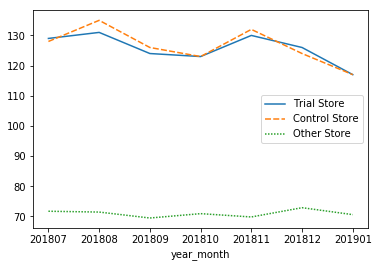

In [235]:
sns.lineplot(data = combine_customer);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


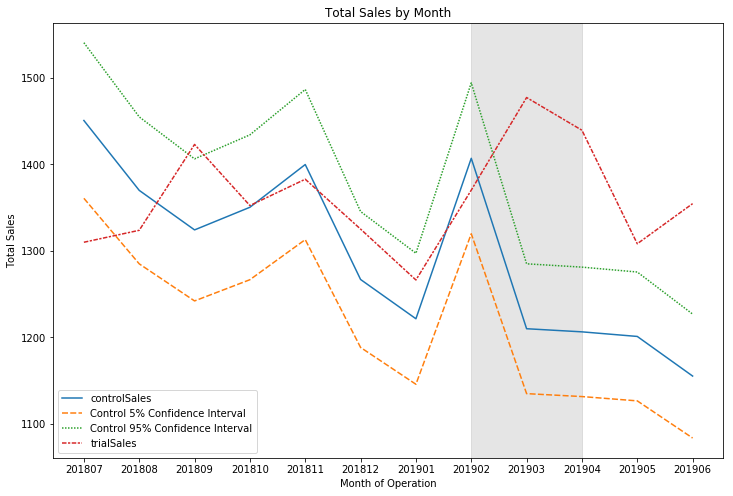

In [237]:
combineSales(trial_store, control_store)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


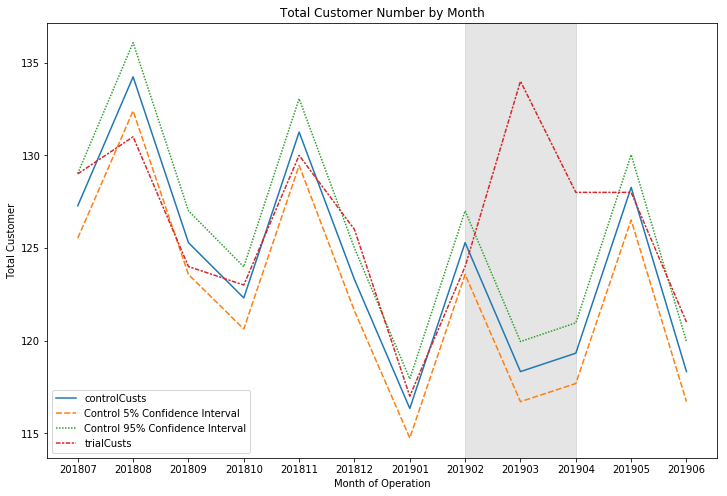

In [236]:
combineCusts(trial_store, control_store)